<a href="https://colab.research.google.com/github/matsunori39/How-Deep-Learning-AI-Works/blob/main/How_Deep_Learning_AI_Works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://info.nikkeibp.co.jp/media/NSW/atcl/books/111100050/

# Chapter 7: Making Sense of Image Recognition AI Code

## 7-2 Prepare training and test data

### Import required modules

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

### Loading training and test data

In [2]:
# image transformation process
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load training data
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=2)

# Load test data
testset = torchvision.datasets.CIFAR10(root='./data',
                                        train=False,
                                        download=True,
                                        transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                          batch_size=4,
                                          shuffle=False,
                                          num_workers=2)

# Define class label names
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Random display of training data images and labels

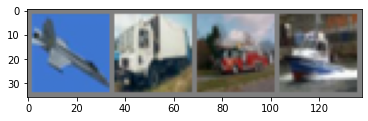

plane truck truck  ship


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 7-3 Write code to implement CNN

### Implement CNN

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  # Define each layer
  def __init__(self):
      super(Net, self).__init__()

      # Convolutional layer 1
      self.conv1 = nn.Conv2d(3, 6, 5)

      # Pooling layer
      self.pool = nn.MaxPool2d(2, 2)

      # Convolutional layer 2
      self.conv2 = nn.Conv2d(6, 16, 5)

      # Fully-Connected layer
      self.fc1 = nn.Linear(16 * 5 * 5, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84,10)
  
  # Define configuration
  def forward(self, x):
    # conv1 and pool
    x = self.pool(F.relu(self.conv1(x)))

    # conv2 and pool
    x = self.pool(F.relu(self.conv2(x)))

    # Sort for fc
    x = x.view(-1, 16 * 5 * 5)

    # fc1
    x = F.relu(self.fc1(x))

    # fc2
    x = F.relu(self.fc2(x))

    # fc3 to output layer
    x = self.fc3(x)
    return x


# Generate CNN
net = Net()

### Define loss functions and optimizers

In [5]:
import torch.optim as optim

# The loss function is a cross-entropy function
criterion = nn.CrossEntropyLoss()

# SGD for optimization
optimizer = optim.SGD(net.parameters(),
                      lr=0.001, momentum=0.9)

## 7-4 Code to learn

In [ ]:
# 2 Epoch Learning
for epoch in range(2):
  running_loss = 0.0

  # Learning as many data sets as there are data sets
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    # Inference with images of training data
    outputs = net(inputs)

    # Losses are determined by the loss function
    loss = criterion(outputs, labels)

    # Find the gradient by back propagation
    loss.backward()

    # Update parameters
    optimizer.step()

    # Calculate and output loss averages for each 2000 mini-batch
    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.212
[1,  4000] loss: 1.898
[1,  6000] loss: 1.694
[1,  8000] loss: 1.583
[1, 10000] loss: 1.498
[1, 12000] loss: 1.459
[2,  2000] loss: 1.398
[2,  4000] loss: 1.372
[2,  6000] loss: 1.340
[2,  8000] loss: 1.307
[2, 10000] loss: 1.297
[2, 12000] loss: 1.292
Finished Training


## 7-5 Let's classify images with test data

### Display images and labels of the top test data

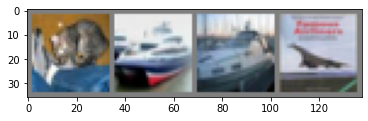

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',
      ' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Classify test data at the top

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car plane


### Classify the second and subsequent test data

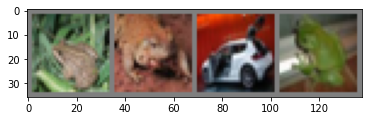

GroundTruth:   frog  frog   car  frog
Predicted:   deer  frog truck  frog


In [ ]:
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',
      ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

### Find the percentage of correct answers for all test data

In [ ]:
correct = 0
total = 0

with torch.no_grad():
  # Classify all test data in order
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)

    # Counting test data and number of correct answers
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

# Find and output the percentage of correct answers
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


### Find the percentage of correct answers per class

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  # Classify all test data in order
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    # Count the number of correct answers per class
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

# Find and output the percentage of correct answers per class
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
      classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 62 %
Accuracy of  bird : 39 %
Accuracy of   cat : 59 %
Accuracy of  deer : 26 %
Accuracy of   dog : 31 %
Accuracy of  frog : 54 %
Accuracy of horse : 61 %
Accuracy of  ship : 78 %
Accuracy of truck : 60 %


## 7-6 With GPUs, learnig time is much shorter

### Check if GPU has been enabled

In [6]:
print(torch.cuda.is_available())

True


### Generate the objects needed to use the GPU

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Enabling GPUs in CNN

In [8]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Learning is handled by GPU

In [9]:
for epoch in range(2):
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    # inputs, labels = data
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.193
[1,  4000] loss: 1.917
[1,  6000] loss: 1.698
[1,  8000] loss: 1.594
[1, 10000] loss: 1.534
[1, 12000] loss: 1.491
[2,  2000] loss: 1.413
[2,  4000] loss: 1.388
[2,  6000] loss: 1.365
[2,  8000] loss: 1.354
[2, 10000] loss: 1.339
[2, 12000] loss: 1.308
Finished Training


### Classification is also done on the GPU

In [10]:
# outputs = net(images)
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  plane truck truck   car


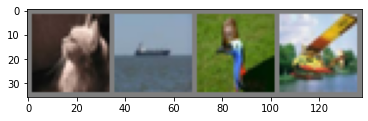

GroundTruth:    cat  ship  bird plane
Predicted:    dog plane  bird   dog


In [11]:
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',
      ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# outputs = net(images)
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [12]:
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    # images, labels = data
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in testloader:
    # images, labels = data
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
      classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 69 %
Accuracy of  bird : 28 %
Accuracy of   cat : 24 %
Accuracy of  deer : 49 %
Accuracy of   dog : 66 %
Accuracy of  frog : 61 %
Accuracy of horse : 67 %
Accuracy of  ship : 65 %
Accuracy of truck : 50 %


# Chapter 9: Experience natural language processing programming

## 9-1 Understand and categorize teh content of the text

In [14]:
!pip install transformers[ja]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 65.3 MB/s 
     |████████████████████████████████| 6.6 MB 52.9 MB/s 
     |████████████████████████████████| 13.4 MB 57.4 MB/s 
     |████████████████████████████████| 568 kB 65.3 MB/s 
     |████████████████████████████████| 47.4 MB 1.5 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=914f6e5dd16c777638d39926ea330a60f9ef00360c094991d0e04a7377344ff3
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
  Created wheel for unidic: filename=unidic-1.1.0-py3-none-any.whl size=7426 sha256=7e728785cba1245de4756fa4a2ae53240af5b908a2b7489dd7f71c454e8e459f
  Stored in directory: /root/.cache/pip/wheels/ce/4d/f1/170bb74b559ca338113c0315c9805e16

### Classify English sentences as positive/negative

In [17]:
# Emotion Analysis  English
from transformers import pipeline

nlp = pipeline("sentiment-analysis")

print(nlp("I love you"))
print(nlp("I hate you"))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9998656511306763}]
[{'label': 'NEGATIVE', 'score': 0.9991129040718079}]


In [18]:
# Emotion Analysis  Japanese
nlp = pipeline("sentiment-analysis",
               model="daigo/bert-base-japanese-sentiment",
               tokenizer="daigo/bert-base-japanese-sentiment")

print(nlp("この商品を買ってよかった。"))
print(nlp("この商品を買って失敗した。"))

Downloading:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/111 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': 'ポジティブ', 'score': 0.9898485541343689}]
[{'label': 'ネガティブ', 'score': 0.8074161410331726}]


In [19]:
print(nlp("このラーメンは好き。"))
print(nlp("このラーメンは好きではない。"))

[{'label': 'ポジティブ', 'score': 0.9830439686775208}]
[{'label': 'ポジティブ', 'score': 0.5454373359680176}]


## 9-2 Experience filling in sentences

### Fill in the blanks with English sentences

In [20]:
# Fill in the blanks  English
nlp = pipeline("fill-mask")

results = nlp(f"I eat {nlp.tokenizer.mask_token} everyday.")
for result in results:
  print(result)

No model was supplied, defaulted to distilroberta-base (https://huggingface.co/distilroberta-base)


Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

{'score': 0.08785649389028549, 'token': 9366, 'token_str': ' pizza', 'sequence': 'I eat pizza everyday.'}
{'score': 0.04193379729986191, 'token': 24351, 'token_str': ' yogurt', 'sequence': 'I eat yogurt everyday.'}
{'score': 0.04071268439292908, 'token': 28287, 'token_str': ' sushi', 'sequence': 'I eat sushi everyday.'}
{'score': 0.03656341880559921, 'token': 29965, 'token_str': ' tacos', 'sequence': 'I eat tacos everyday.'}
{'score': 0.03347095102071762, 'token': 4884, 'token_str': ' meat', 'sequence': 'I eat meat everyday.'}


### Fill in the blanks with Japanese sentences

In [21]:
# Fill in the blanks  Japanese
from transformers import BertConfig, AutoTokenizer, BertForMaskedLM

config = BertConfig.from_pretrained(
    'cl-tohoku/bert-base-japanese-whole-word-masking')
tokenizer = AutoTokenizer.from_pretrained(
    'cl-tohoku/bert-base-japanese-whole-word-masking')
model = BertForMaskedLM.from_pretrained(
    'cl-tohoku/bert-base-japanese-whole-word-masking')

nlp = pipeline('fill-mask', model=model,
               tokenizer=tokenizer, config=config)

results = nlp('朝食に [MASK] を食べる。')

for result in results:
  print(result)

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'score': 0.09675180166959763, 'token': 3469, 'token_str': 'パ ン', 'sequence': '朝食 に パン を 食べる 。'}
{'score': 0.07346049696207047, 'token': 885, 'token_str': '米', 'sequence': '朝食 に 米 を 食べる 。'}
{'score': 0.06376329809427261, 'token': 25965, 'token_str': '朝 食', 'sequence': '朝食 に 朝食 を 食べる 。'}
{'score': 0.05316410958766937, 'token': 12396, 'token_str': 'カ レ ー', 'sequence': '朝食 に カレー を 食べる 。'}
{'score': 0.05232246220111847, 'token': 5299, 'token_str': 'ワ イ ン', 'sequence': '朝食 に ワイン を 食べる 。'}


In [22]:
results = nlp('夕食に [MASK] を食べる。')

for result in results:
  print(result)

{'score': 0.09346076101064682, 'token': 8845, 'token_str': '野 菜', 'sequence': '夕食 に 野菜 を 食べる 。'}
{'score': 0.0688197910785675, 'token': 885, 'token_str': '米', 'sequence': '夕食 に 米 を 食べる 。'}
{'score': 0.06190985068678856, 'token': 5299, 'token_str': 'ワ イ ン', 'sequence': '夕食 に ワイン を 食べる 。'}
{'score': 0.056245673447847366, 'token': 12396, 'token_str': 'カ レ ー', 'sequence': '夕食 に カレー を 食べる 。'}
{'score': 0.03625887632369995, 'token': 3469, 'token_str': 'パ ン', 'sequence': '夕食 に パン を 食べる 。'}


In [23]:
results = nlp('猫が餌を食べないのは、それが [MASK] だから。')

for result in results:
  print(result)

{'score': 0.33351510763168335, 'token': 2424, 'token_str': '原 因', 'sequence': '猫 が 餌 を 食べ ない の は 、 それ が 原因 だから 。'}
{'score': 0.11930151283740997, 'token': 1515, 'token_str': '理 由', 'sequence': '猫 が 餌 を 食べ ない の は 、 それ が 理由 だから 。'}
{'score': 0.03815353289246559, 'token': 12844, 'token_str': '嫌 い', 'sequence': '猫 が 餌 を 食べ ない の は 、 それ が 嫌い だから 。'}
{'score': 0.02783256582915783, 'token': 6981, 'token_str': '悪 い', 'sequence': '猫 が 餌 を 食べ ない の は 、 それ が 悪い だから 。'}
{'score': 0.01800486072897911, 'token': 3370, 'token_str': '大 き い', 'sequence': '猫 が 餌 を 食べ ない の は 、 それ が 大きい だから 。'}


### Split words in BERT

In [24]:
text1 = '猫が餌を食べない。'
ids = tokenizer.encode(text1, return_tensors='pt')

print(tokenizer.convert_ids_to_tokens(ids[0].tolist()))

['[CLS]', '猫', 'が', '餌', 'を', '食べ', 'ない', '。', '[SEP]']
